<a href="https://colab.research.google.com/github/mcdeheeger/MSDS-422/blob/master/msds422_asgmt_2_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import required modules
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import sklearn.linear_model
import matplotlib.pyplot as plt  # static plotting
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns  # pretty plotting, including heat map
sns.set(style="darkgrid")

In [0]:
# Preliminary investigation into the components of training and testing datasets
print("Training Data\n")
url_train = 'https://raw.githubusercontent.com/mcdeheeger/MSDS-422/master/asgmt-2-house-train.csv'
df_train = pd.read_csv(url_train)

print(df_train.head())
print(df_train.describe())
print(df_train.columns.values)

print("\nTest Data\n")
url_test = 'https://raw.githubusercontent.com/mcdeheeger/MSDS-422/master/asgmt-2-house-test.csv'
df_test = pd.read_csv(url_test)

print(df_test.head())
print(df_test.describe())
print(df_test.columns.values)


Training Data

   Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]
                Id   MSSubClass  ...       YrSold      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  20

In [0]:
# One less column for the test data since final sale price not shown
print("Train data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [0]:
# Show first five entries of the training dataset
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
# Quantitative summary of target variable
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.8828757597682129


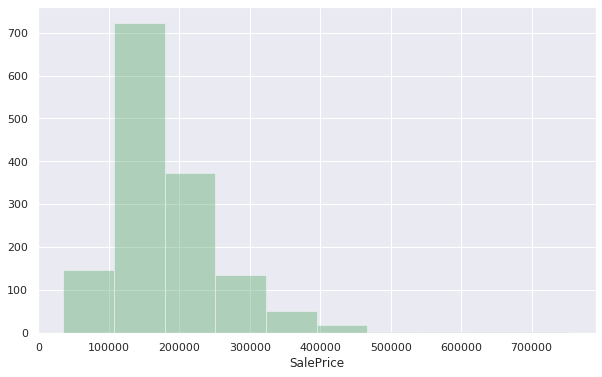

In [0]:
# Show distribution of sales prices of homes to gain an understanding of the target variable
# The distribution is positively skewed, suggesting that we may need to transform the data
print("Skewness:", df_train.SalePrice.skew())
sns.distplot(df_train.SalePrice, bins = 10, kde = False, color='g')
plt.show()

Skewness: 0.12133506220520406


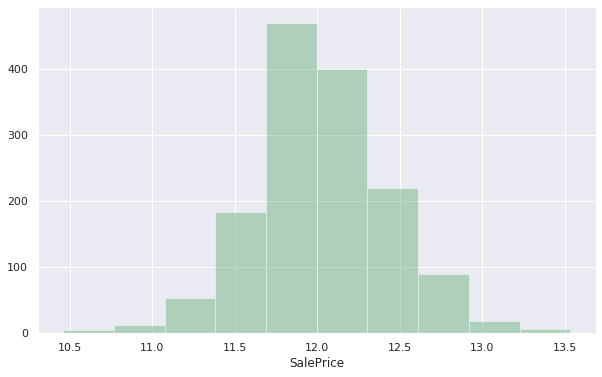

In [0]:
# Transforming the train dataset to have a more normal distribution
log_SalePrice = np.log(df_train.SalePrice)
print("Skewness:", log_SalePrice.skew())
sns.distplot(log_SalePrice, bins = 10, kde = False, color='g')
plt.show()

In [0]:
# Identify the numeric features
# Only 38 of 81 features are numeric
numeric_features = df_train.select_dtypes(include=[np.number])
print(numeric_features.shape)
print(numeric_features.dtypes)

(1460, 38)
Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object


In [0]:
# Examine the relationship between then target variable and numeric features
# The overall quality appears to be the most positively correlated feature
corr = numeric_features.corr()
print(corr['SalePrice'].sort_values(ascending=False)[:5], "\n")
print(corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [0]:
# Identify the unique labels for the overall quality feature
# They appear to be the range between 1-10
df_train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [0]:
# Create a pivot table showing the median value of homes with each of the overall 
# quality indicators
quality_pivot = df_train.pivot_table(values='SalePrice', index='OverallQual', aggfunc='median')
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


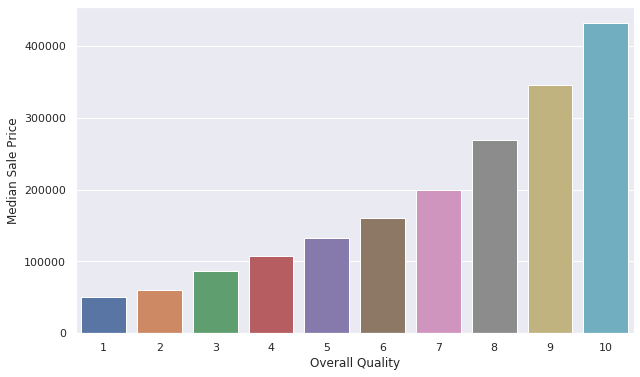

In [0]:
# Create a bar chart showing the median sale price as it relates to overall quality
sns.barplot(x=quality_pivot.index, y=quality_pivot['SalePrice'], data=quality_pivot)
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

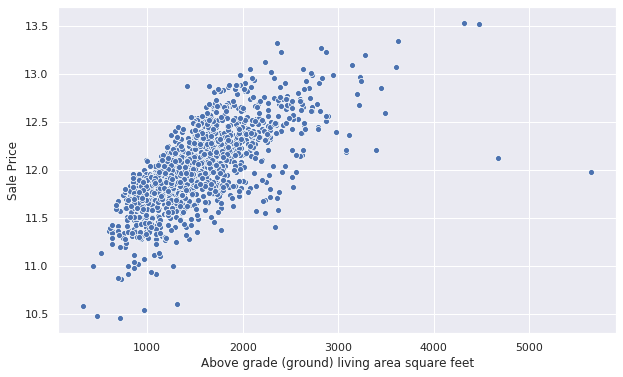

In [0]:
# Create a scatterplot showing how living space relates to sales price
sns.scatterplot(x=df_train['GrLivArea'], y=log_SalePrice)
plt.xlabel('Above grade (ground) living area square feet')
plt.ylabel('Sale Price')
plt.show()

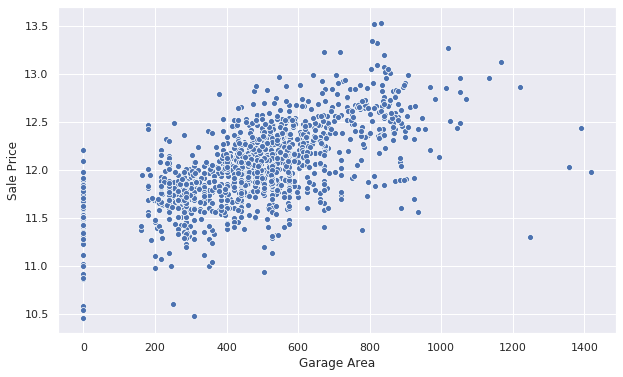

In [0]:
# Create a scatterplot showing how garage area relates to sales price
sns.scatterplot(x=df_train['GarageArea'], y=log_SalePrice)
plt.xlabel('Garage Area')
plt.ylabel('Sale Price')
plt.show()

In [0]:
# Remove the entries that appear to be outliers in the dataset
df_train = df_train[df_train['GarageArea'] < 1200]

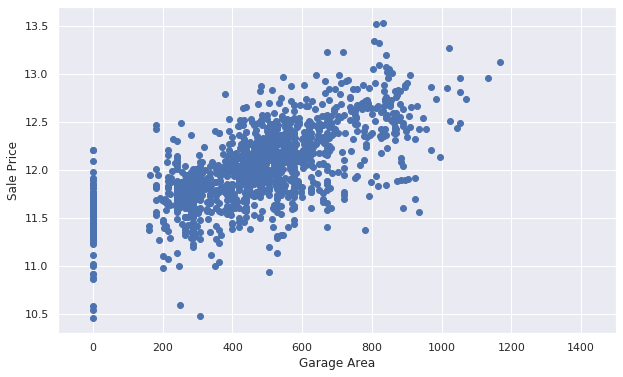

In [0]:
# Plot the scatterplot again with the outliers removed
plt.scatter(x=df_train['GarageArea'], y=np.log(df_train.SalePrice))
plt.xlim(-100, 1500)
plt.xlabel('Garage Area')
plt.ylabel('Sale Price')
plt.show()

In [0]:
# Investigate how many features have null or zero values and how many there are
# for each feature
nulls = pd.DataFrame(df_train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81


In [0]:
# See what categories there are within the miscellaneous features feature
print('Unique values of miscellaneous features are:', df_train.MiscFeature.unique())

Unique values of miscellaneous features are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [0]:
# Considering the non-numeric features
categoricals = df_train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1447,1455,1455,1455,1418,1418,1417,1418,1417,1455,1455,1455,1454,1455,1455,766,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,7,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,1441,1216,722,1139,1430,514,503,863,905,1278,644,647,1306,951,428,1251,1423,737,1360,1329,733,1355,377,867,605,1306,1321,1335,2,157,48,1266,1196


In [45]:
# How many of each of the foundation style categories are there in the dataset?
print(df_train.Foundation.value_counts(), '\n')

PConc     644
CBlock    632
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64 



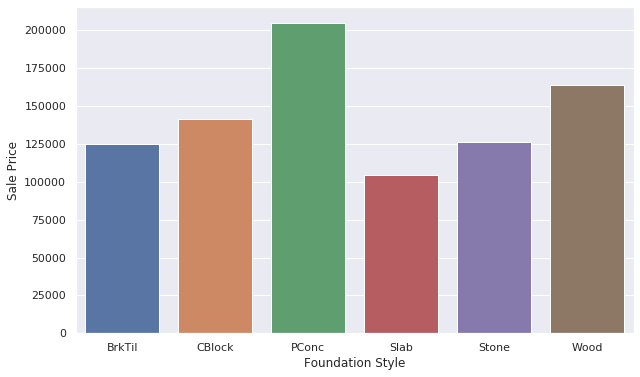

In [0]:
# Make a pivot table that shows foundation type versus sales price
Foundation_pivot = df_train.pivot_table(index='Foundation', values='SalePrice', aggfunc=np.median)
sns.barplot(x=Foundation_pivot.index, y=Foundation_pivot.SalePrice, data=Foundation_pivot)
plt.xlabel('Foundation Style')
plt.ylabel('Sale Price')
plt.show()

In [0]:
# Make the PConc Foundation 1 and everything else 0 in order to boolean this feature
def encode(x):
  return 1 if x == 'PConc' else 0
df_train['enc_Foundation'] = df_train.Foundation.apply(encode)
df_test['enc_Foundation'] = df_test.Foundation.apply(encode)

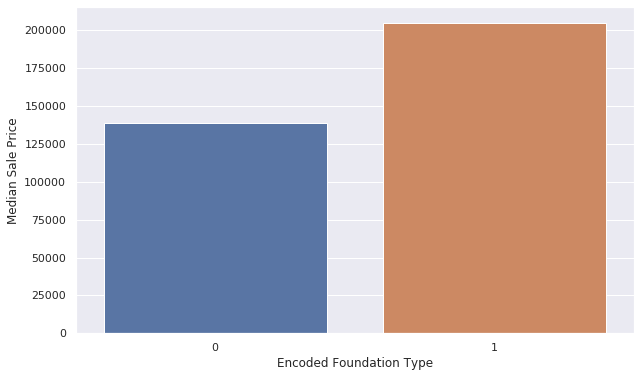

In [0]:
# Remake the pivot table graph
Foundation_pivot = df_train.pivot_table(index='enc_Foundation', values='SalePrice', aggfunc=np.median)
sns.barplot(x=Foundation_pivot.index, y=Foundation_pivot.SalePrice, data=Foundation_pivot)
plt.xlabel('Encoded Foundation Type')
plt.ylabel('Median Sale Price')
plt.show()

In [0]:
# How many of each of the street categories are there in the dataset?
print('Original: \n')
print(df_train.Street.value_counts(), '\n')

Original: 

Pave    1450
Grvl       5
Name: Street, dtype: int64 



In [0]:
# Convert the categorical data into numerical boolean data
# In this case, we are taking the Pave and Grvl categories and changing them to a 1 or 0
df_train['enc_street'] = pd.get_dummies(df_train.Street, drop_first=True)
df_test['enc_street'] = pd.get_dummies(df_train.Street, drop_first=True)
print('Encoded: \n')
print(df_train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


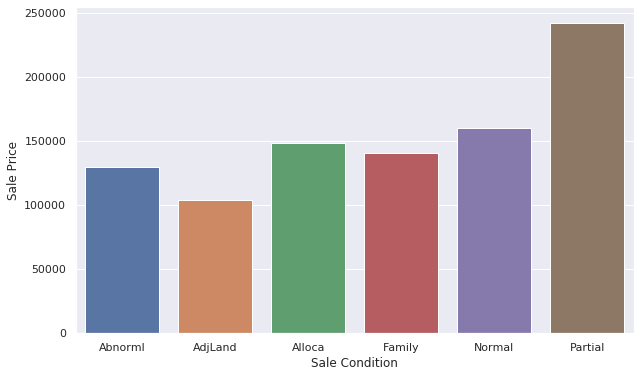

In [0]:
# Make another pivot table that shows condition versus sales price
condition_pivot = df_train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
sns.barplot(x=condition_pivot.index, y=condition_pivot.SalePrice, data=condition_pivot)
plt.xlabel('Sale Condition')
plt.ylabel('Sale Price')
plt.show()

In [0]:
# Make the partially complete condition 1 and everything else in order to boolean this feature
def encode(x):
  return 1 if x == 'Partial' else 0
df_train['enc_condition'] = df_train.SaleCondition.apply(encode)
df_test['enc_condition'] = df_test.SaleCondition.apply(encode)

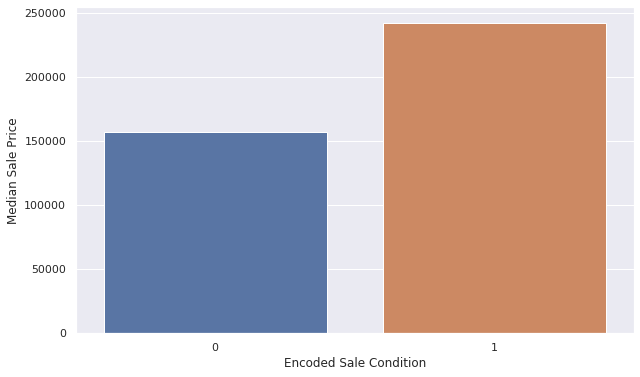

In [0]:
# Remake the pivot table graph
condition_pivot = df_train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
sns.barplot(x=condition_pivot.index, y=condition_pivot.SalePrice, data=condition_pivot)
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.show()

In [0]:
# Remove null values and replace with average value
data = df_train.select_dtypes(include=[np.number]).interpolate().dropna()
sum(data.isnull().sum() !=0)

0

In [0]:
# Remove unecesary columns for inserting into the model
y = np.log(df_train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [0]:
# Import the follwing sklearn package to create a train/test split and assign
# data to each
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [0]:
# Instantiate a linear regression model
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [0]:
# Fit the data to the model
model = lr.fit(X_train, y_train)

In [0]:
# Calculate the R^2 value
print('R^2 is: \n', model.score(X_test, y_test))

R^2 is: 
 0.8901264735172166


In [0]:
# Create predictions using the generated test set
predictions = model.predict(X_test)

In [0]:
# Calculate the root mean squared error to score the model
from sklearn.metrics import mean_squared_error
print('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.01754185038539562


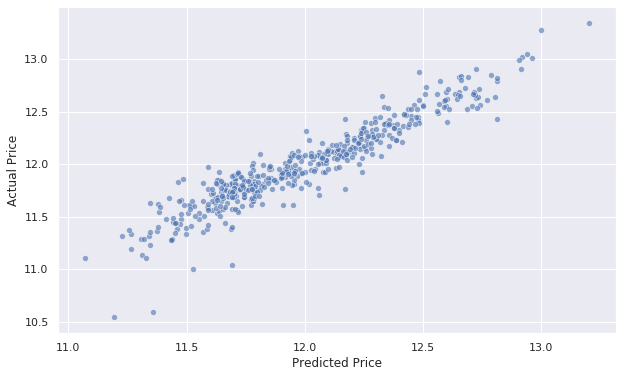

In [0]:
# Plot the predicted values generated from the model against the actual values of the test set
actual_values = y_test
sns.scatterplot(x=predictions, y=actual_values, alpha=.6)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

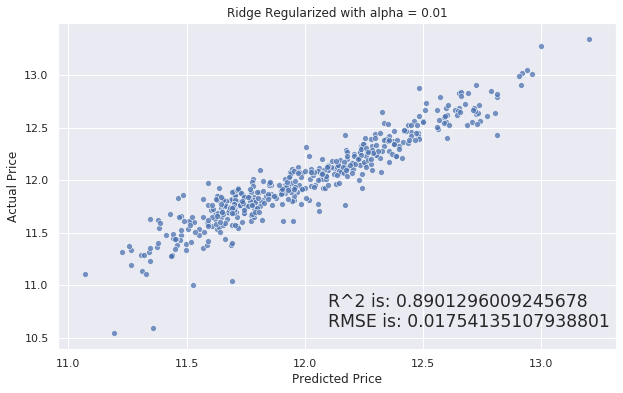

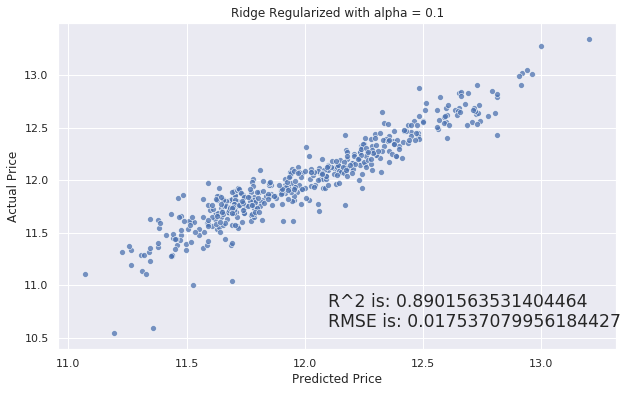

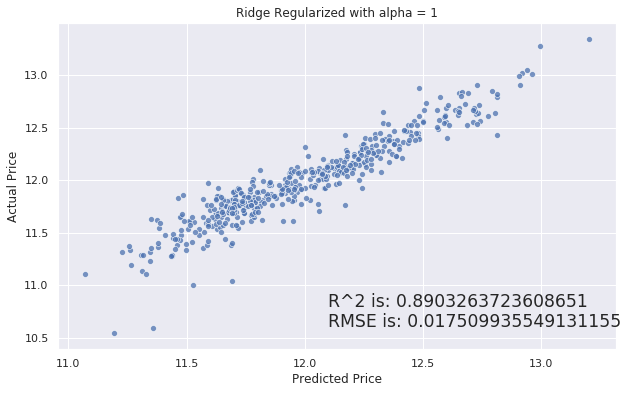

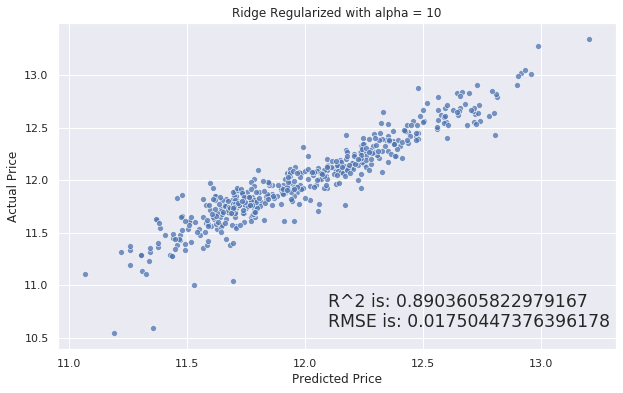

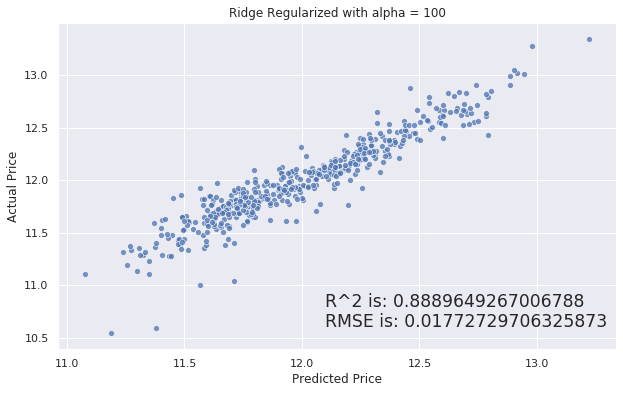

In [0]:
# Apply ridge regularization to minimize the impact of less relevant features
for i in range (-2,3):
  alpha = 10**i
  rm = linear_model.Ridge(alpha=alpha)
  ridge_model = rm.fit(X_train, y_train)
  preds_ridge = ridge_model.predict(X_test)

  sns.scatterplot(x=preds_ridge, y=actual_values, alpha=.75)
  plt.xlabel('Predicted Price')
  plt.ylabel('Actual Price')
  plt.title('Ridge Regularized with alpha = {}'.format(alpha))
  overlay = 'R^2 is: {}\nRMSE is: {}'.format(
      ridge_model.score(X_test, y_test),
      mean_squared_error(y_test, preds_ridge))
  plt.annotate(s=overlay, xy=(12.1, 10.6), size='x-large')
  plt.show()

In [0]:
# Generate a CSV file for submission on Kaggle after returning predictions to original format
submission = pd.DataFrame()
submission['Id'] = df_test.Id
feats = df_test.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()
predictions = model.predict(feats)
final_predictions = np.exp(predictions)

In [0]:
print('Original predictions are: \n', predictions[:5], "\n")
print('Final predictions are: \n', final_predictions[:5])

Original predictions are: 
 [11.7661685  11.7535032  12.09813305 12.22664655 12.12087186] 

Final predictions are: 
 [128819.63136602 127198.38079257 179536.3642119  204157.40111864
 183665.57628529]


In [0]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,128819.631366
1,1462,127198.380793
2,1463,179536.364212
3,1464,204157.401119
4,1465,183665.576285


In [0]:
submission.to_csv('deh_housing_subm2', index=False)